In [1]:
import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 
import pandas as pd
from datetime import datetime 

from keras.utils import normalize
#from keras.metrics import MeanIoU

Segmentation Models: using `keras` framework.


In [2]:
#Resizing images, if needed
SIZE_X = 128 
SIZE_Y = 128
n_classes=4 #Number of classes for segmentation

#Capture training image info as a list
train_images = []


In [3]:
for directory_path in glob.glob("original_images/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 1)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)
    
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("masked_images/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [4]:
###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)


/home/ankit/Desktop/ml/Tensorflow_ENV/tfenv/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3])

In [5]:
#################################################
#train_images = np.expand_dims(train_images, axis=3)
#train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.5, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 


Class values in the dataset are ...  [0 1 2 3]


In [6]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))


In [7]:
######################################################
#Reused parameters in all models

n_classes=4
activation='softmax'

LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]


In [8]:
########################################################################

BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)
#####################################################################


In [9]:
############################################################
###Model 2
#Using the same backbone as unet

# define model (Change to unet or Linknet based on the need )
model2 = sm.Linknet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)


2024-07-25 14:17:11.554219: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-25 14:17:11.564321: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-25 14:17:11.564649: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-25 14:17:11.565527: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [10]:
# compile keras model with defined optimozer, loss and metrics
model2.compile(optim, total_loss, metrics=metrics)

print(model2.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

                                                                                                  
 stage1_unit3_bn1 (BatchNormali  (None, None, None,   256        ['add_1[0][0]']                  
 zation)                        64)                                                               
                                                                                                  
 stage1_unit3_relu1 (Activation  (None, None, None,   0          ['stage1_unit3_bn1[0][0]']       
 )                              64)                                                               
                                                                                                  
 zero_padding2d_6 (ZeroPadding2  (None, None, None,   0          ['stage1_unit3_relu1[0][0]']     
 D)                             64)                                                               
                                                                                                  
 stage1_un

                                128)                              'add_3[0][0]']                  
                                                                                                  
 stage2_unit3_bn1 (BatchNormali  (None, None, None,   512        ['add_4[0][0]']                  
 zation)                        128)                                                              
                                                                                                  
 stage2_unit3_relu1 (Activation  (None, None, None,   0          ['stage2_unit3_bn1[0][0]']       
 )                              128)                                                              
                                                                                                  
 zero_padding2d_12 (ZeroPadding  (None, None, None,   0          ['stage2_unit3_relu1[0][0]']     
 2D)                            128)                                                              
          

 add_7 (Add)                    (None, None, None,   0           ['stage3_unit1_conv2[0][0]',     
                                256)                              'stage3_unit1_sc[0][0]']        
                                                                                                  
 stage3_unit2_bn1 (BatchNormali  (None, None, None,   1024       ['add_7[0][0]']                  
 zation)                        256)                                                              
                                                                                                  
 stage3_unit2_relu1 (Activation  (None, None, None,   0          ['stage3_unit2_bn1[0][0]']       
 )                              256)                                                              
                                                                                                  
 zero_padding2d_18 (ZeroPadding  (None, None, None,   0          ['stage3_unit2_relu1[0][0]']     
 2D)      

                                                                                                  
 stage3_unit5_bn1 (BatchNormali  (None, None, None,   1024       ['add_10[0][0]']                 
 zation)                        256)                                                              
                                                                                                  
 stage3_unit5_relu1 (Activation  (None, None, None,   0          ['stage3_unit5_bn1[0][0]']       
 )                              256)                                                              
                                                                                                  
 zero_padding2d_24 (ZeroPadding  (None, None, None,   0          ['stage3_unit5_relu1[0][0]']     
 2D)                            256)                                                              
                                                                                                  
 stage3_un

                                512)                              'stage4_unit1_sc[0][0]']        
                                                                                                  
 stage4_unit2_bn1 (BatchNormali  (None, None, None,   2048       ['add_13[0][0]']                 
 zation)                        512)                                                              
                                                                                                  
 stage4_unit2_relu1 (Activation  (None, None, None,   0          ['stage4_unit2_bn1[0][0]']       
 )                              512)                                                              
                                                                                                  
 zero_padding2d_30 (ZeroPadding  (None, None, None,   0          ['stage4_unit2_relu1[0][0]']     
 2D)                            512)                                                              
          

 decoder_stage0c_conv (Conv2D)  (None, None, None,   32768       ['decoder_stage0b_relu[0][0]']   
                                256)                                                              
                                                                                                  
 decoder_stage0c_bn (BatchNorma  (None, None, None,   1024       ['decoder_stage0c_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 decoder_stage0c_relu (Activati  (None, None, None,   0          ['decoder_stage0c_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 decoder_stage0_add (Add)       (None, None, None,   0           ['decoder_stage0c_relu[0][0]',   
          

                                                                                                  
 decoder_stage3a_relu (Activati  (None, None, None,   0          ['decoder_stage3a_bn[0][0]']     
 on)                            16)                                                               
                                                                                                  
 decoder_stage3_upsampling (UpS  (None, None, None,   0          ['decoder_stage3a_relu[0][0]']   
 ampling2D)                     16)                                                               
                                                                                                  
 decoder_stage3b_conv (Conv2D)  (None, None, None,   2304        ['decoder_stage3_upsampling[0][0]
                                16)                              ']                               
                                                                                                  
 decoder_s

In [11]:
start2 = datetime.now()

In [12]:
history2=model2.fit(X_train1, 
          y_train_cat,
          batch_size=8, 
          epochs=50,
          verbose=1,
          validation_data=(X_test1, y_test_cat))

Epoch 1/50


2024-07-25 14:17:24.685638: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


2/2 [==============================] - 21s 6s/step - loss: 0.9977 - iou_score: 0.0625 - f1-score: 0.1095 - val_loss: 1.2127 - val_iou_score: 0.1155 - val_f1-score: 0.1580
Epoch 2/50
2/2 [==============================] - 1s 548ms/step - loss: 0.9931 - iou_score: 0.0720 - f1-score: 0.1225 - val_loss: 1.1960 - val_iou_score: 0.1156 - val_f1-score: 0.1581
Epoch 3/50
2/2 [==============================] - 1s 534ms/step - loss: 0.9925 - iou_score: 0.0725 - f1-score: 0.1226 - val_loss: 1.1815 - val_iou_score: 0.1156 - val_f1-score: 0.1582
Epoch 4/50
2/2 [==============================] - 1s 537ms/step - loss: 0.9878 - iou_score: 0.0785 - f1-score: 0.1329 - val_loss: 1.1707 - val_iou_score: 0.1157 - val_f1-score: 0.1582
Epoch 5/50
2/2 [==============================] - 1s 527ms/step - loss: 0.9834 - iou_score: 0.0858 - f1-score: 0.1420 - val_loss: 1.1608 - val_iou_score: 0.1158 - val_f1-score: 0.1583
Epoch 6/50
2/2 [==============================] - 1s 529ms/step - loss: 0.9814 - iou_score: 0

2/2 [==============================] - 1s 530ms/step - loss: 0.9355 - iou_score: 0.2592 - f1-score: 0.3401 - val_loss: 0.9664 - val_iou_score: 0.1320 - val_f1-score: 0.1791
Epoch 46/50
2/2 [==============================] - 1s 524ms/step - loss: 0.9337 - iou_score: 0.2758 - f1-score: 0.3553 - val_loss: 0.9661 - val_iou_score: 0.1289 - val_f1-score: 0.1777
Epoch 47/50
2/2 [==============================] - 1s 532ms/step - loss: 0.9308 - iou_score: 0.2821 - f1-score: 0.3595 - val_loss: 0.9658 - val_iou_score: 0.1241 - val_f1-score: 0.1747
Epoch 48/50
2/2 [==============================] - 1s 524ms/step - loss: 0.9292 - iou_score: 0.2939 - f1-score: 0.3694 - val_loss: 0.9659 - val_iou_score: 0.1173 - val_f1-score: 0.1694
Epoch 49/50
2/2 [==============================] - 1s 535ms/step - loss: 0.9270 - iou_score: 0.3074 - f1-score: 0.3807 - val_loss: 0.9656 - val_iou_score: 0.1139 - val_f1-score: 0.1678
Epoch 50/50
2/2 [==============================] - 1s 540ms/step - loss: 0.9288 - iou_s

In [13]:
stop2 = datetime.now()

#Execution time of the model 
execution_time_linknet = stop2-start2
print("Linknet execution time is: ", execution_time_linknet)

Linknet execution time is:  0:01:18.902528


In [15]:
model2.save('linknet_res34_backbone_50epochs.hdf5')

# convert the history.history dict to a pandas DataFrame:     
hist2_df = pd.DataFrame(history2.history) 
hist2_csv_file = 'history_linknet.csv'
with open(hist2_csv_file, mode='w') as f:
    hist2_df.to_csv(f)
##########################################################

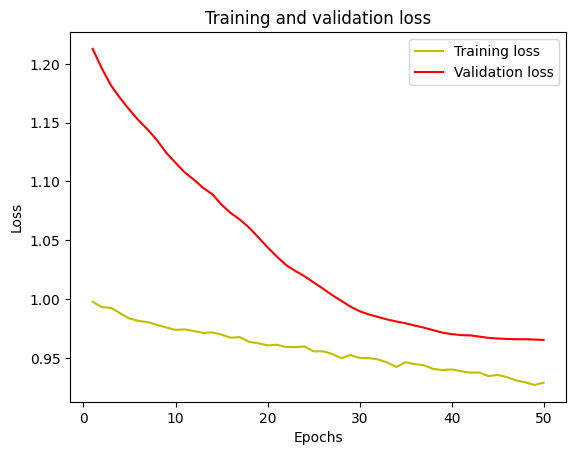

In [16]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

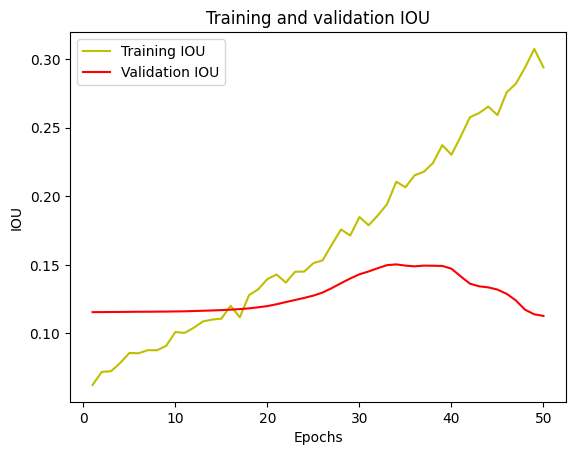

In [17]:
acc = history2.history['iou_score']
val_acc = history2.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()


In [18]:
####################################################

from keras.models import load_model

### FOR NOW LET US FOCUS ON A SINGLE MODEL

#Set compile=False as we are not loading it for training, only for prediction.
model_unet = load_model('unet_res34_backbone_50epochs.hdf5', compile=False)
model_linknet = load_model('linknet_res34_backbone_50epochs.hdf5', compile=False)


In [19]:
#IOU
y_pred_unet=model_unet.predict(X_test1)
y_pred_unet_argmax=np.argmax(y_pred_unet, axis=3)

y_pred_linknet=model_linknet.predict(X_test1)
y_pred_linknet_argmax=np.argmax(y_pred_linknet, axis=3)

1/1 [==============================] - 1s 922ms/step


In [20]:
#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 4

IOU_unet = MeanIoU(num_classes=n_classes)  
IOU_unet.update_state(y_test[:,:,:,0], y_pred_unet_argmax)

IOU_linknet = MeanIoU(num_classes=n_classes)  
IOU_linknet.update_state(y_test[:,:,:,0], y_pred_linknet_argmax)

print("Mean IoU using Unet =", IOU_unet.result().numpy())
print("Mean IoU using linknet =", IOU_linknet.result().numpy())

Mean IoU using Unet = 0.4287852
Mean IoU using linknet = 0.29065728


In [25]:
##############################################################


import random
test_img_number = random.randint(0, len(X_test1))
test_img = X_test1[test_img_number]

In [26]:
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
test_img_input1 = preprocess_input1(test_img_input)

test_pred_unet = model_unet.predict(test_img_input1)
test_prediction_unet = np.argmax(test_pred_unet, axis=3)[0,:,:]

test_pred_linknet = model_linknet.predict(test_img_input1)
test_prediction_linknet = np.argmax(test_pred_linknet, axis=3)[0,:,:]

1/1 [==============================] - 1s 671ms/step


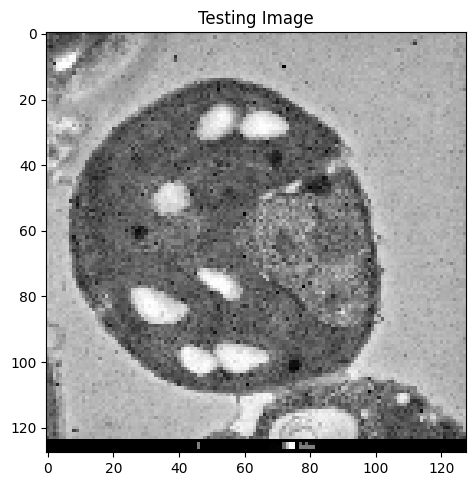

In [27]:
plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.show()

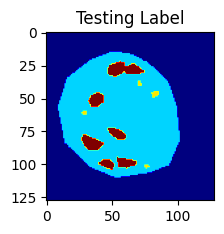

In [28]:
plt.subplot(222)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.show()

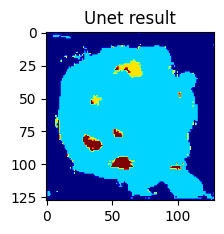

In [29]:
plt.subplot(223)
plt.title('Unet result')
plt.imshow(test_prediction_unet, cmap='jet')
plt.show()

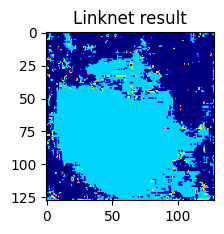

In [30]:
plt.subplot(224)
plt.title('Linknet result')
plt.imshow(test_prediction_linknet, cmap='jet')
plt.show()

In [32]:
###################################################################################
from patchify import patchify, unpatchify

#Set compile=False as we are not loading it for training, only for prediction.
#model_unet = load_model('saved_models/unet_res34_backbone_50epochs.hdf5', compile=False)
#model_linknet = load_model('saved_models/linknet_res34_backbone_50epochs.hdf5', compile=False)

start3 = datetime.now() 

segm_images = []
path = "original_images/*.png"
from pathlib import Path
for file in glob.glob(path):
    #print(file)     #just stop here to see all file names printed
    name = Path(file).stem #Get the original file name
    #print(name)
  
    large_image = cv2.imread(file, 1)
    
    patches = patchify(large_image, (128, 128, 3), step=128)  #Step=256 for 256 patches means no overlap
    
    predicted_patches = []
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            print(i,j)
            
            single_patch = patches[i,j,0, :,:]
            
            single_patch = np.expand_dims(single_patch, 0)
            single_patch_input=preprocess_input1(single_patch)
    
            single_patch_prediction = (model_linknet.predict(single_patch_input))
            single_patch_predicted_img=np.argmax(single_patch_prediction, axis=3)[0,:,:]
    
            predicted_patches.append(single_patch_predicted_img)
    
    predicted_patches = np.array(predicted_patches)
    
    predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], 128,128) )
    
    reconstructed_image = unpatchify(predicted_patches_reshaped, (large_image.shape[0], large_image.shape[1]))
    #Here you can save individual images, or save on milti_dim tiff file
    #cv2.imwrite('segmented_images/' + name + '_segmented.tif', reconstructed_image)
    segm_images.append(reconstructed_image)
    print("Finished segmenting image: ", name)
    
    
final_segm_image = np.array(segm_images).astype(np.uint8)   

from tifffile import imsave
imsave('segmented_images/sandstone_segmented_test2.tif', final_segm_image)
    
stop3 = datetime.now()

#Execution time of the model 
#prediction_time_unet = stop3-start3
prediction_time_linknet = stop3-start3
print("Linknet prediction time is: ", prediction_time_linknet)

0 0
1/1 [==============================] - 0s 26ms/step
0 1
1/1 [==============================] - 0s 26ms/step
0 2
1/1 [==============================] - 0s 29ms/step
0 3
1/1 [==============================] - 0s 29ms/step
0 4
1/1 [==============================] - 0s 27ms/step
0 5
1/1 [==============================] - 0s 25ms/step
0 6
1/1 [==============================] - 0s 27ms/step
0 7
1/1 [==============================] - 0s 33ms/step
1 0
1/1 [==============================] - 0s 43ms/step
1 1
1/1 [==============================] - 0s 32ms/step
1 2
1/1 [==============================] - 0s 33ms/step
1 3
1/1 [==============================] - 0s 32ms/step
1 4
1/1 [==============================] - 0s 28ms/step
1 5
1/1 [==============================] - 0s 34ms/step
1 6
1/1 [==============================] - 0s 28ms/step
1 7
1/1 [==============================] - 0s 27ms/step
2 0
1/1 [==============================] - 0s 32ms/step
2 1
1/1 [==============================] - 0s 30

KeyboardInterrupt: 